# Confirming the postprocessing to a desired micromotion phase with influence functions (Fig. 4)

The aim of this notebook is to reproduce the Fig. 4 from the paper 'Unsupervised machine learning of topological phase transitions from experimental data' by N. Kaming, A. Dawid, K. Kottmann, K. Sengstock, M. Lewenstein, A. Dauphin, and C. Weitenberg as well as give a possibility of analyzing other test points than chosen for the mentioned figure.

## Creating training, validation, and test sets for a single cut through the experimental phase diagram
We have:
- the original experimental data gathered across the limited ranges of shaking frequencies for a shaking phase of -90&deg;, deep in the phases (see Fig. 2c in Rem et al. 2019. Nat. Phys. 15, 917) with various micromotion phases: 'validation_single_cut_56.h5' in folder 'data' and the post-processed version with a fixed micromotion phase 'validation_single_cut_rephased.h5' in folder 'data' - they will serve as the source for the training and validation sets
- the original experimental data gathered across the full range of shaking frequencies for a shaking phase of -90&deg;, with various micromotion phases: 'single_cut_56.h5' in folder 'data' and the post-processed version with a fixed micromotion phase 'single_cut_rephased.h5' in folder 'data' - they will serve as the source for test sets

We will:
- label the dataset accordingly to theoretically predicted boundaries: topological phase occurs for 6.1-6.8 kHz
- generate the training, validation, and test sets, taking care that they're not too large, for the sake of simplicity of the final plot (which aims to show that the micromotion phase is an influential factor for the classification of original data, and is no longer influential after post-proccessing the data to a fixed micromotion phase, as expected)
- use the same training, validation, and test masks for the experimental data before and after fixing the micromotion phase (see data_loader.py)
- re-run for both datasets in order to get the means and standard deviations needed for normalization (see data_loader.py)

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import h5py
from lib.utility_general import keys

SAVE = False

## Load experimental data (either with the fixed micromotion phase or various ones, we will use identical training, validation, and test masks for both datasets)
# We need to re-run this cell for both datasets in order to get the means and standard deviations needed for normalization (see data_loader.py)
data = h5py.File('./data/validation_single_cut_56.h5', 'r')
test_data = h5py.File('./data/single_cut_56.h5', 'r')
#data = h5py.File('./data/validation_single_cut_rephased.h5', 'r')
#test_data = h5py.File('./data/single_cut_rephased.h5', 'r')

print(keys(data['parameter']))
print(keys(test_data['parameter']))

# Extract chosen properties from the h5 files
images = np.array(data['images'])
freq = np.array(data['parameter/freq']) # from 5.1 to 7.8 kHz, every 0.1
hold = np.array(data['parameter/hold'])
labels = np.array(data['parameter/chern_number'])
micromotion = np.array(data['parameter/micromotion_phase'])

test_images = np.array(test_data['images'])
test_freq = np.array(test_data['parameter/freq'])
test_hold = np.array(test_data['parameter/hold'])
test_micromotion = np.array(test_data['parameter/micromotion_phase'])

# Transform labels of 1 (Chern no = 0) and 2 (Chern no = -1) to 0 and 1
print("Before transforming the labels:", np.unique(labels))
labels = labels - 1
print("After transforming the labels:", np.unique(labels))

# Restrict the training data set to data with hold time smaller than 1
training_size = 0
indices = np.array([])
indices0 = np.array([]) # For the plot with the training and test sets
indices1 = np.array([]) # For the plot with the training and test sets

for j in np.arange(hold.shape[0]):
   # Hold time restricted to smaller than 1
   if hold[j] <= 1:
      training_size = training_size + 1
      indices = np.append(indices, j)

      if labels[j] == 1: # Chern no. = -1
         indices1 = np.append(indices1, j)
      else:
         indices0 = np.append(indices0, j)

## Generate and save labels for the test data according to theoretically predicted boundaries: topo for 6.1-6.8 kHz
test_labels = np.array([])
for i in np.arange(test_images.shape[0]):
   if (freq[i] < 6.1 or freq[i] > 6.8):
      test_labels = np.append(test_labels, 1) 
   else:
      test_labels = np.append(test_labels, 0)

if SAVE is True:
    np.save('influence/data_and_masks/single_cut_theoretical_labels.npy', test_labels.astype(int))

# Create a smaller test set (than very dense experimental data) and make sure it's spread nicely across the frequencies and micromotion phases
chosen_freq = np.arange(5, 8.1, 0.25)
chosen_micromotion = np.arange(0, 6.1, 1)

test_size = 0
chosen_test_indices = np.array([])
for j in np.arange(test_hold.shape[0]):
   if test_hold[j] <= 1:
      if any(np.isclose(test_freq[j], f, atol=0.05) for f in chosen_freq):
         if any(np.isclose(test_micromotion[j], f, atol=0.07) for f in chosen_micromotion):
            chosen_test_indices = np.append(chosen_test_indices, j)

# Training and validation masks
validation_size = 145
mask = np.arange(len(indices))
np.random.seed(0)
np.random.shuffle(mask)
validation_mask = indices[mask][:validation_size]
training_mask = indices[mask][validation_size:]

if SAVE is True:
   np.save('influence/data_and_masks/validation_single_cut_training_mask.npy', training_mask.astype(int))
   np.save('influence/data_and_masks/validation_single_cut_validation_mask.npy', validation_mask.astype(int))
   np.save('influence/data_and_masks/validation_single_cut_theoretical_labels.npy', labels.astype(int))

print("Final training set size: ", len(training_mask))
print("Final validation set size: ", len(validation_mask))

# Test mask
chosen_test_size = 20
test_mask = np.arange(len(chosen_test_indices))
np.random.seed(0)
np.random.shuffle(test_mask)
final_test_mask = chosen_test_indices[test_mask[:chosen_test_size]]

if SAVE is True:
   np.save('influence/data_and_masks/single_cut_test_mask.npy', final_test_mask.astype(int))

print("Maximum test set size (after shrinking, making sure it remains representative, and removal of large hold times):", len(chosen_test_indices))
print("Chosen test set size:", len(final_test_mask)) # to compute influence functions for test samples across the single cut, but keep calculation time decent

# See the final training and test set vs. the shaking frequency and original micromotion phase
plt.rcParams.update({"pgf.texsystem": "pdflatex", "pgf.preamble": [r"\usepackage[utf8x]{inputenc}", r"\usepackage[T1]{fontenc}", r"\usepackage{cmbright}",]})
plt.rc('text', usetex=True)

plt.scatter(freq[indices0.astype(int).tolist()], micromotion[indices0.astype(int).tolist()]  / np.pi, c = 'steelblue')
plt.scatter(freq[indices1.astype(int).tolist()], micromotion[indices1.astype(int).tolist()]  / np.pi, c = 'firebrick')
plt.scatter(test_freq[np.sort(final_test_mask).astype(int).tolist()], test_micromotion[np.sort(final_test_mask).astype(int).tolist()]  / np.pi, c = 'olivedrab')
plt.ylabel('Micromotion phase / $\pi$')
plt.xlabel('Shaking frequency / kHz')
plt.show()

# Means and std deviations for normalization
images = np.array(images)
training_images = images[training_mask.astype(int)]
mean = np.mean(training_images)
std = np.std(training_images)
print("Mean: ", mean)
print("Standard deviation: ", std)

training_images = (training_images - mean) / std
print("After normalization:")
print("Mean: ", np.mean(training_images))
print("Standard deviation: ", np.std(training_images))

['amp', 'chern_number', 'freq', 'hold', 'id', 'micromotion_phase']
['amp', 'freq', 'hold', 'id', 'micromotion_phase']
Before transforming the labels: [1. 2.]
After transforming the labels: [0. 1.]
Final training set size:  800
Final validation set size:  145
Maximum test set size (after shrinking, making sure it remains representative, and removal of large hold times): 361
Chosen test set size: 20


<Figure size 640x480 with 1 Axes>

Mean:  0.07900989899839451
Standard deviation:  0.044015503630440524
After normalization:
Mean:  -1.2778893589563027e-17
Standard deviation:  0.9999999999999993


## Training the model on experimental data: WITHOUT and WITH fixed micromotion phase
We have:
- the original experimental data gathered across the full range of shaking frequencies for a shaking phase of -90&deg;, with various micromotion phases: 'single_cut_56.h5' in folder 'data'
- the post-processed experimental data gathered across the full range of shaking frequencies for a shaking phase of -90&deg;, with a fixed micromotion phase 'single_cut_56_rephased_2.000_best.h5' in folder 'data'

We will:
- train two models - one on experimental data with various micromotion phases (experimental_model_with_micromotion_single_cut) and one on data with fixed micromotion phase (experimental_model_rephased_single_cut) OR
- skip this step and use in next steps the published and trained models 'published_model_with_micromotion_single_cut' and 'published_model_rephased_single_cut' (set PUBLISHED_MODEL to True)

In [2]:
import torch
import torch.nn as nn
from torch.nn import Sequential, CrossEntropyLoss
import torch.optim as optim

from matplotlib import pyplot as plt

from lib.data import Downloader
from lib.CNN_for_IF import CNN2D

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PUBLISHED_MODEL = True

if PUBLISHED_MODEL is True:
    λ_micromotion = 0.05
    λ_rephased = 0.5

folder_model = 'networks/influence'

# Hyper-parameters
input_size = 56*56
no_classes = 2 # topological and topologically-trivial, Chern numbers = 0 and -1
batch_size = 800

# Loading experimental data
dataset_with_micromotion = Downloader('single_cut_with_micromotion', batch_size)
rephased_dataset = Downloader('single_cut_rephased', batch_size)

training_set_size = dataset_with_micromotion.training_samples_no() # == rephased_dataset.training_samples_no()

cuda:0


In [3]:
## TRAINING TWO MODELS: ONE ON DATA WITH VARIOUS MICROMOTION PHASES, ONE WITH A FIXED MICROMOTION PHASE

# To reproduce the training from the paper
np.random.seed(0)
torch.manual_seed(17)

if PUBLISHED_MODEL is False:
    for i in range(2):
        if i == 0:
            dataset = dataset_with_micromotion
            model_name = 'experimental_model_with_micromotion_single_cut'
            λ_micromotion = 0.05 # Regularization, we need to save this quantity for further calculations
            λ = λ_micromotion
            learning_rate = 0.1
            num_epochs = 50
            milestones = [10]

        if i == 1:
            dataset = rephased_dataset
            model_name = 'experimental_model_rephased_single_cut'
            λ_rephased = 0.5 # Regularization, we need to save this quantity for further calculations
            λ = λ_rephased
            learning_rate = 0.01
            num_epochs = 60
            milestones = [50]

        train_loader = dataset.train_loader()
        validation_loader = dataset.validation_loader(batch_size=validation_size)
        print("Data loaded.")

        model = CNN2D(no_classes=2)
        model.to(device)
        print("Model built.")

        print("Number of parameters of the net: ", sum(p.numel() for p in model.parameters() if p.requires_grad))
        # 1741 - 3class, 1540 - 2class

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
        #optimizer = torch.optim.Adam(micromotion_model.parameters()) # lr = 0.001
        #scheduler = None
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
        #scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2)

        # Train the model
        hold_loss=[]
        hold_val_loss = []
        for epoch in range(num_epochs):

            for phase in ['train', 'val']:

                if phase == 'train':
                    model.train()  # Set model to training mode

                    for i, (eigenvectors, labels) in enumerate(train_loader):
                        # Reshape eigenvectors to (batch_size, # of RGB channels, size, size)
                        eigenvectors = eigenvectors.reshape(-1, 1, 56, 56)

                        eigenvectors, labels = eigenvectors.to(device), labels.to(device)

                        # Forward pass
                        outputs = model(eigenvectors)
                        #print(outputs.shape)
                        loss = criterion(outputs, labels)
            
                        # We manually add L2 regularization
                        if λ != 0:
                            l2_reg = 0.0
                            for param in model.parameters():
                                l2_reg += torch.norm(param)**2
                            loss += 1/training_set_size * λ/2 * l2_reg

                        # Backward and optimize
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                
                    print ('Epoch [{}/{}], Train loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

                    hold_loss.append(loss.item())

                if phase == 'val':
                    model.eval()  # Set model to evaluating mode

                    with torch.no_grad():
                        correct = 0
                        for eigenvectors, labels in validation_loader:
                            eigenvectors = eigenvectors.reshape(-1, 1, 56, 56)

                            eigenvectors, labels = eigenvectors.to(device), labels.to(device)

                            outputs = model(eigenvectors)
                            _, predicted = torch.max(outputs.data, 1)  # classification
                            #print ("Prediction is: ", predicted)  # classification
                            val_loss = criterion(outputs, labels)
                            # We manually add L2 regularization
                            if λ != 0:
                                l2_reg = 0.0
                                for param in model.parameters():
                                    l2_reg += torch.norm(param)**2
                                val_loss += 1/training_set_size * λ/2 * l2_reg

                            correct = (predicted == labels).sum().item()  # classification

                        hold_val_loss.append(val_loss.item())
                        print("Accuracy of the model on the", len(labels), "validation images:", 100 * correct / len(labels), "%")
                
                    print ('Epoch [{}/{}], Validation loss: {:.4f}'.format(epoch+1, num_epochs, val_loss.item()))

                    if scheduler is not None:
                        scheduler.step() # here for milestones scheduler
                        #scheduler.step(val_loss) # here for Plateau scheduler

        plt.plot(hold_loss, label="training loss")
        plt.plot(hold_val_loss, label="validation loss")
        plt.xlabel('epochs')
        plt.title("Losses plots")
        plt.legend()
        plt.show()

        # Save the model checkpoint
        torch.save(model.state_dict(), folder_model + '/' + model_name + '.pt')

## Test both models
We have:
- either two trained models from the previous step OR we chose to use the published models
- test sets with and without fixed micromotion

We will:
- test both models on corresponding test sets
- save the test losses (needed for influence functions)

Accuracy will be much smaller than for the training and validation sets - test set contains points from the boundaries which are absent in the training and validation sets.

In [3]:
## Test the models on the testing data and save all test losses (needed for influence functions' calculations)
from lib.utility_general import save_to_file

for i in range(2):
    if i == 0:
        dataset = dataset_with_micromotion
        λ = λ_micromotion
        if PUBLISHED_MODEL is True:
            model_name = 'published_model_with_micromotion_single_cut'
        else:
            model_name = 'experimental_model_with_micromotion_single_cut'

    if i == 1:
        dataset = rephased_dataset
        λ = λ_rephased
        if PUBLISHED_MODEL is True:
            model_name = 'published_model_rephased_single_cut'
        else:
            model_name = 'experimental_model_rephased_single_cut'

    test_loader = dataset.test_loader()

    model = CNN2D(no_classes=2)    
    model.load_state_dict(torch.load(folder_model + '/' + model_name + '.pt'))
    model.to(device)
    model.eval()

    criterion = nn.CrossEntropyLoss(reduction='none')

    with torch.no_grad():
        correct = 0
        for eigenvectors, labels in test_loader:
            eigenvectors = eigenvectors.reshape(-1, 1, 56, 56)

            eigenvectors, labels = eigenvectors.to(device), labels.to(device)

            outputs = model(eigenvectors)
            _, predicted = torch.max(outputs.data, 1)  # classification
            test_loss = criterion(outputs, labels)
            
            # We manually add L2 regularization
            if λ != 0:
                l2_reg = 0.0
                for param in model.parameters():
                    l2_reg += torch.norm(param)**2
                    test_loss += 1/training_set_size * λ/2 * l2_reg

            correct = (predicted == labels).sum().item()  # classification

            predicted_labels_storage = np.array(predicted.cpu()) # it flattens a tuple of tensors to 1D tensor (and then converts tensor to numpy array)
            predicted_loss_storage = np.array(test_loss.cpu())

            if i == 0:
                print("Accuracy of the micromotion model on the", len(labels), "test images:", 100 * correct / len(labels), "%")
            else:
                print("Accuracy of the rephased model on the", len(labels), "test images:", 100 * correct / len(labels), "%")

    # Save the test losses
    save_to_file(np.array(predicted_loss_storage), 'all_test_losses_' + model_name + '.txt', folder_model)

Accuracy of the micromotion model on the 20 test images: 75.0 %
Accuracy of the rephased model on the 20 test images: 70.0 %


## Calculating the hessians
We have:
- either two trained models from the previous step OR we chose to use the published models

We will:
- calculate two Hessians of the training loss with respect to two models' parameters
OR
- skip this step and use the calculated Hessians for the published models

In [5]:
## HESSIAN FOR MODEL TRAINED ON VARIOUS MICROMOTION PHASES
## Calculate the hessian (or skip this step if you use the published model)
from lib.influence_function import find_heigenvalues, find_hessian
from lib.utility_general import save_to_file

folder_influence = 'influence'

for i in range(2):
    if i == 0:
        dataset = dataset_with_micromotion
        λ = λ_micromotion
        if PUBLISHED_MODEL is True:
            model_name = 'published_model_with_micromotion_single_cut'
        else:
            model_name = 'experimental_model_with_micromotion_single_cut'
    else:
        dataset = rephased_dataset
        λ = λ_rephased
        if PUBLISHED_MODEL is True:
            model_name = 'published_model_rephased_single_cut'
        else:
            model_name = 'experimental_model_rephased_single_cut'
    
    train_loader = dataset.train_loader(batch_size=training_set_size)

    model = CNN2D(no_classes=2)      
    model.load_state_dict(torch.load(folder_model + '/' + model_name + '.pt'))
    model.to(device)
    print("Model built and loaded.")

    criterion = nn.CrossEntropyLoss()

    # Compute and save Hessian and its eigenvalues
    for _, (eigenvectors, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, # of RGB channels, size, size)
        eigenvectors = eigenvectors.reshape(-1, 1, 56, 56) #(batch_size, 25, 50)

        eigenvectors, labels = eigenvectors.to(device), labels.to(device)

        # Forward pass
        outputs = model(eigenvectors)
        loss = criterion(outputs, labels)

        # We manually add L2 regularization
        if λ != 0:
            l2_reg = 0.0
            for param in model.parameters():
                l2_reg += torch.norm(param)**2
            loss += 1/training_set_size * λ/2 * l2_reg

        hessian = find_hessian(loss, model)
        #hessian = torch.autograd.functional.hessian(criterion)
        np.save(folder_influence + '\\' + model_name + '_hessian', hessian)
        heigenvalues = np.sort(np.linalg.eigvalsh(hessian))
        if i == 0:
            print("Largest negative eigenvalue of the Hessian of the micromotion model: ", np.amin(heigenvalues))
        else:
            print("Largest negative eigenvalue of the Hessian of the rephased model: ", np.amin(heigenvalues))
        save_to_file(heigenvalues, model_name + '_heigenvalues.txt', folder_influence)

Model built and loaded.



Largest negative eigenvalue of the Hessian of the micromotion model:  -1.0113814
Model built and loaded.



Largest negative eigenvalue of the Hessian of the rephased model:  -0.34660795


## Calculating the influence functions
We have:
- either the trained models from the previous step OR we chose to use the published models
- the Hessians of the training loss w.r.t. the models' parameters
- test losses for all test points

We will:
- calculate the influence functions between the chosen test points and the whole training set for both models
OR
- skip this step and use the calculated influence functions for the published models

In [9]:
## Calculate influence functions for chosen test points and all training points for both models (for i in range(2))
from lib.utility_general import save_to_file, flatten_grad
from lib.influence_function import grad_z, find_heigenvalues, find_hessian
from lib.utility_general import save_to_file
from tqdm.notebook import trange # for the progress bar

damping = [1.05, 0.4] # needs to be a little larger than the absolute value of the largest negative eigenvalue of the hessian. For both models
model_params_no = 1540 # 1540 for 2 classes, 1741 for 3 classes

# Choose test points, e.g.:
chosen_test_examples = np.array([14]) #np.arange(20), 14th test sample is plotted in the published figure

for i in range(2):
    if i == 0:
        λ = λ_micromotion
        if PUBLISHED_MODEL is True:
            model_name = 'published_model_with_micromotion_single_cut'
            final_folder_influence = folder_influence + '/published_influence_micromotion_single_cut'
        else:
            model_name = 'experimental_model_with_micromotion_single_cut'
            final_folder_influence = folder_influence + '/influence_micromotion_single_cut'
        
        training_set_size = dataset_with_micromotion.training_samples_no()
        train_loader = dataset_with_micromotion.train_loader(batch_size=training_set_size)
        test_loader = dataset_with_micromotion.test_loader()

    if i == 1:
        λ = λ_rephased
        if PUBLISHED_MODEL is True:
            model_name = 'published_model_rephased_single_cut'
            final_folder_influence = folder_influence + '/published_influence_rephased_single_cut'
        else:
            model_name = 'experimental_model_rephased_single_cut'
            final_folder_influence = folder_influence + '/influence_rephased_single_cut'
        
        training_set_size = rephased_dataset.training_samples_no()
        train_loader = rephased_dataset.train_loader(batch_size=training_set_size)
        test_loader = rephased_dataset.test_loader()

    model = CNN2D(no_classes=2)
    model.load_state_dict(torch.load(folder_model + '/' + model_name + '.pt'))

    for _, (eigenvectors, labels) in enumerate(train_loader):
        # Reshape images to (batch_size, # of RGB channels, size, size)
        eigenvectors = eigenvectors.reshape(-1, 1, 56, 56)
        
        # Forward pass
        hessian_outputs = model(eigenvectors)
        hessian_loss = criterion(hessian_outputs, labels)

        # We manually add L2 regularization
        if λ != 0:
            l2_reg = 0.0
            for param in model.parameters():
                l2_reg += torch.norm(param)**2
            hessian_loss += 1/training_set_size * λ/2 * l2_reg

        hessian = np.load(folder_influence + '\\' + model_name + '_hessian.npy')
        damped_hessian = hessian + np.identity(model_params_no)*damping[i]
        #print(np.linalg.eigvalsh(damped_hessian))
        inv_hessian = torch.inverse(torch.from_numpy(damped_hessian)).float()
        print("The full Hessian got inverted.")
        np.save(folder_influence + '\\' + model_name + '_invhessian.npy', inv_hessian)
        #inv_hessian = torch.from_numpy(np.load(folder_influence + '/' + model_name + '_invhessian.npy')).float()

        for _, (test_eigenvectors, test_labels) in enumerate(test_loader):
            
            test_eigenvectors = test_eigenvectors.reshape(-1, 1, 56, 56)
                
            for test_index in trange(len(chosen_test_examples), desc='calculating influence for chosen test examples'):

                test_example = chosen_test_examples[test_index]
                print("Looking at the test example no. ", test_example, " right now.")

                grad_test_loss = grad_z(test_eigenvectors[test_example:test_example+1], test_labels[test_example:test_example+1], model, criterion, training_set_size, λ=λ)
                grad_test_loss = flatten_grad(grad_test_loss)
                s_test = torch.mv(inv_hessian, grad_test_loss)

                print("s_test for the test example no. ", test_example, " will be multiplied by gradients right now.")

                influence = []
                for train_example in trange(training_set_size, desc='calculating influence for all training points'):

                    grad_train_loss = grad_z(eigenvectors[train_example:train_example+1], labels[train_example:train_example+1], model, criterion, training_set_size, λ=λ)
                    grad_train_loss = flatten_grad(grad_train_loss)

                    influence_function = - torch.dot(s_test, grad_train_loss) * (- 1 / training_set_size)
                    influence.append(influence_function.item())

                save_to_file(influence, 'exact_influence_test' + str(test_example) + '.txt', final_folder_influence)
                print("Done.")

The full Hessian got inverted.


Looking at the test example no.  14  right now.
s_test for the test example no.  14  will be multiplied by gradients right now.



Done.

The full Hessian got inverted.


Looking at the test example no.  14  right now.
s_test for the test example no.  14  will be multiplied by gradients right now.



Done.



## Final plot
We have:
- either the trained models from the previous step OR we chose to use the published models
- influence functions for the chosen test points and all training points

We will:
- reproduce the fig. 4 from the paper with results produced within this notebook (set PUBLISHED_RESULTS to False) OR
- reproduce the fig. 4 from the paper with published results (set PUBLISHED_RESULTS to True)

You can play with the chosen test point. The one that is in the paper has an index 14.

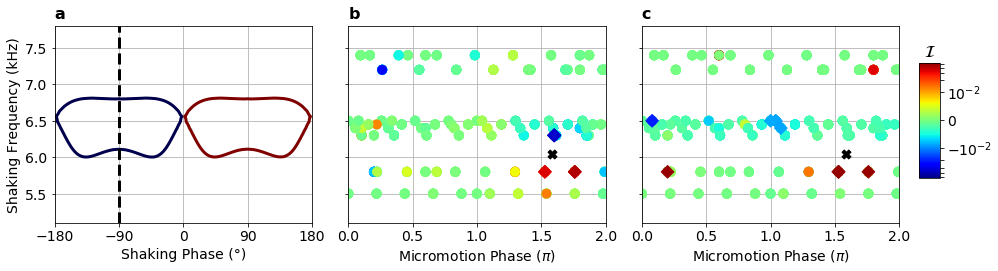

In [2]:
from lib.utility_plots import make_micromotion_removal_plot
import numpy as np

PUBLISHED_RESULTS = True
folder_influence = 'influence'

if PUBLISHED_RESULTS is True:
    folder_influence_before = folder_influence + '/published_influence_micromotion_single_cut'
    folder_influence_after = folder_influence + '/published_influence_rephased_single_cut'
    chosen_test_point = 14
else:
    folder_influence_before = folder_influence + '/influence_micromotion_single_cut'
    folder_influence_after = folder_influence + '/influence_rephased_single_cut'
    chosen_test_point = 14

make_micromotion_removal_plot(chosen_test_point, folder_influence_before, folder_influence_after)